In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
from functools import partial
from scipy.optimize import minimize

import torch
import torch.optim as optim

from nflows.flows import MaskedAutoregressiveFlow

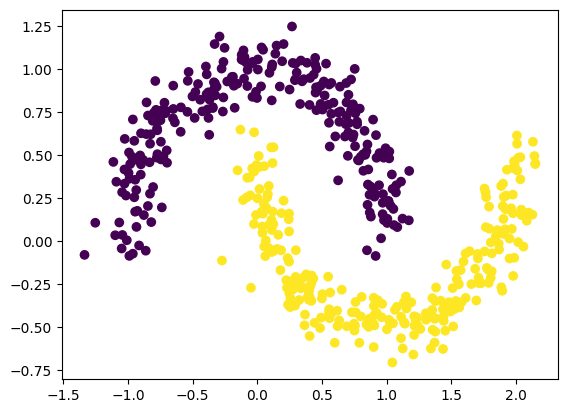

In [2]:
x, y = datasets.make_moons(512, noise=0.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [3]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
optimizer = optim.Adam(flow.parameters())

In [4]:
num_iter = 3000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    if (i + 1) % 500 == 0:
        print(loss.item())

0.7834340333938599
0.47282204031944275
0.5435969829559326
0.32657527923583984
0.49822917580604553
0.3785102665424347


$$agmin\quad d(x, x’) - \lambda (log p(x’|y’) - log(p(x’|y=0) + p(x’|y=1)))$$

In [109]:
y_0 = torch.Tensor([[0.0]])
y_1 = torch.Tensor([[1.0]])
# x = [0.7,  0.01]
x = [1.,  0.]

def optim_f(x_hat, x_i, model, y_orig, y_hat, alpha=1.0):
    with torch.no_grad():
        x_i = torch.Tensor([x_i])
        x_hat = torch.Tensor([x_hat])
        p_orig = model.log_prob(x_hat, context=y_orig).detach().exp().item()
        p_hat = model.log_prob(x_hat, context=y_hat).detach().exp().item()
        dist = np.linalg.norm(x_i-x_hat)
        return - alpha*p_hat + dist

res = minimize(optim_f, x, method="Powell", args=(x, flow, y_0, y_1, 2))
res.x

array([ 1.21945597, -0.46955369])

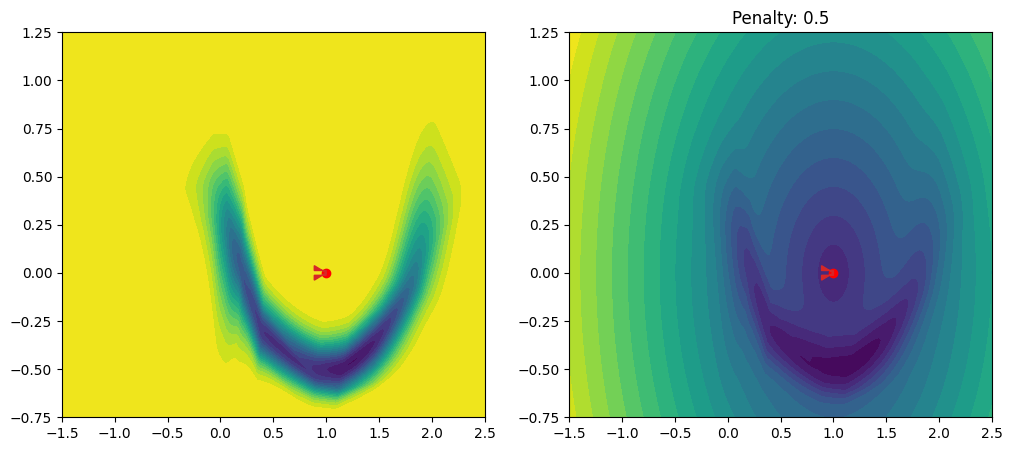

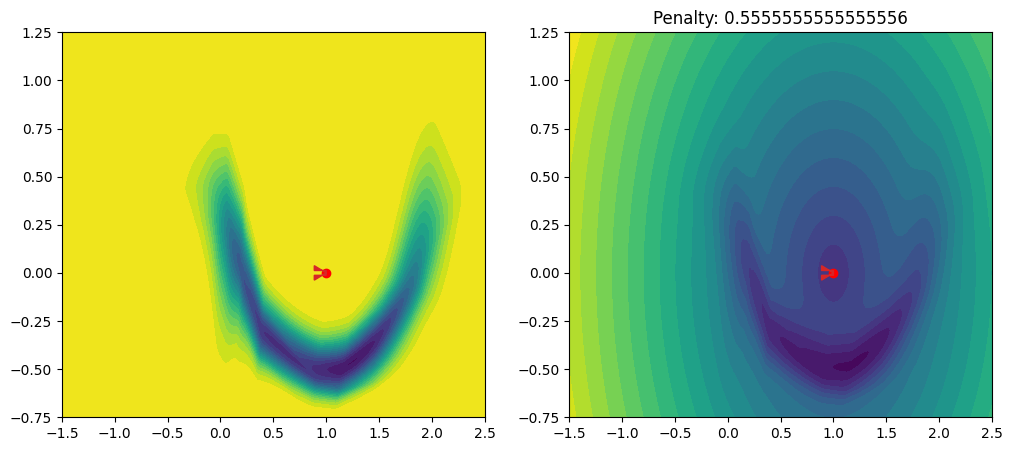

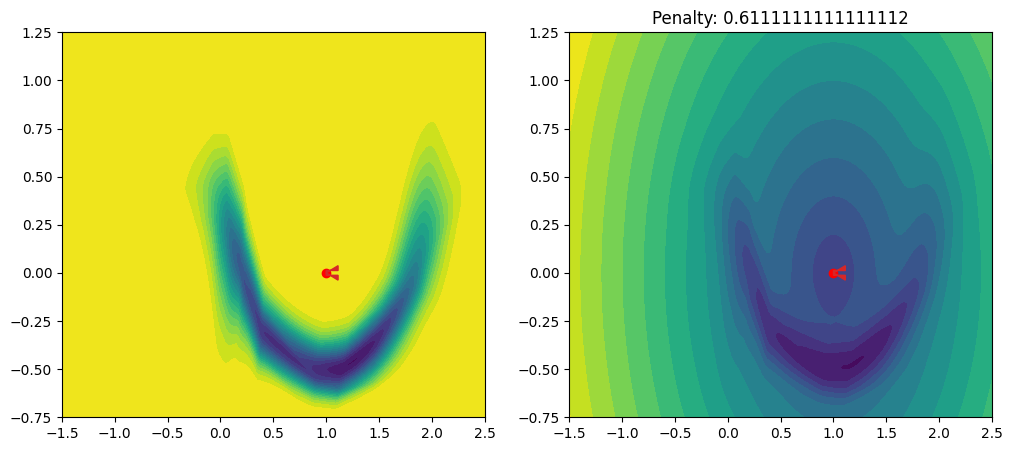

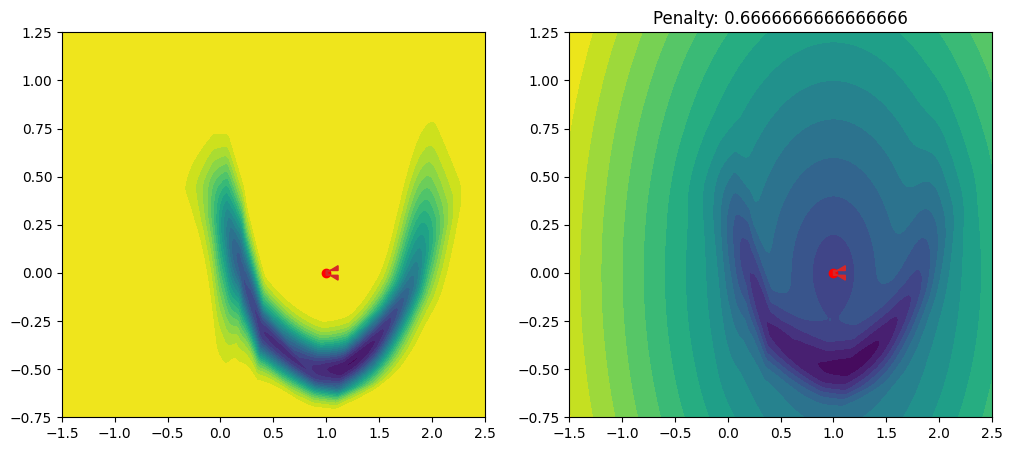

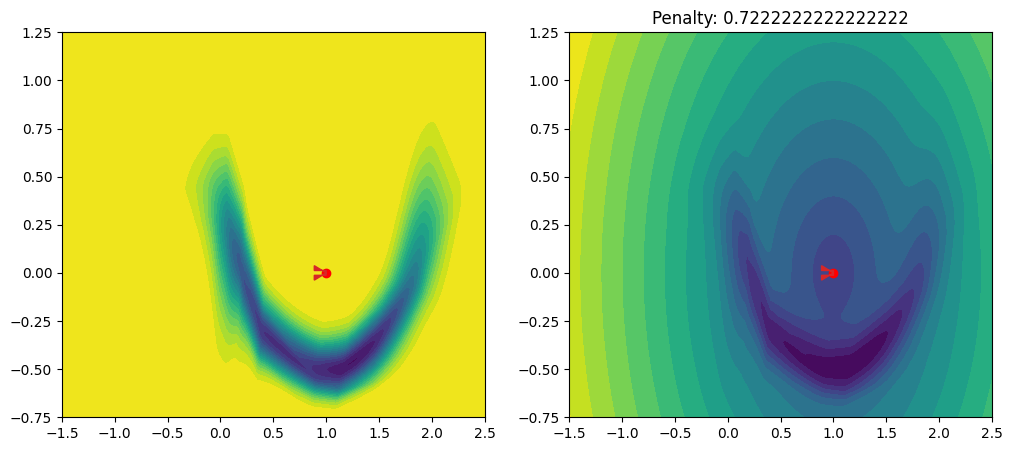

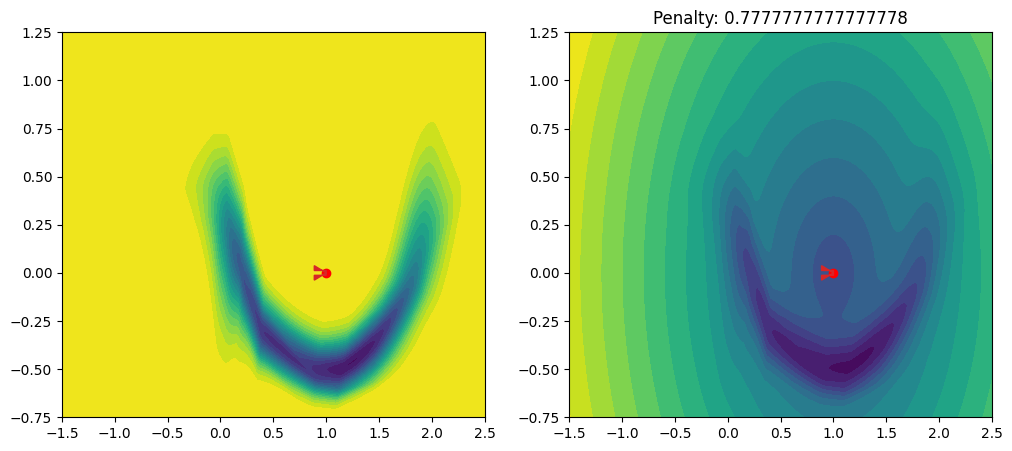

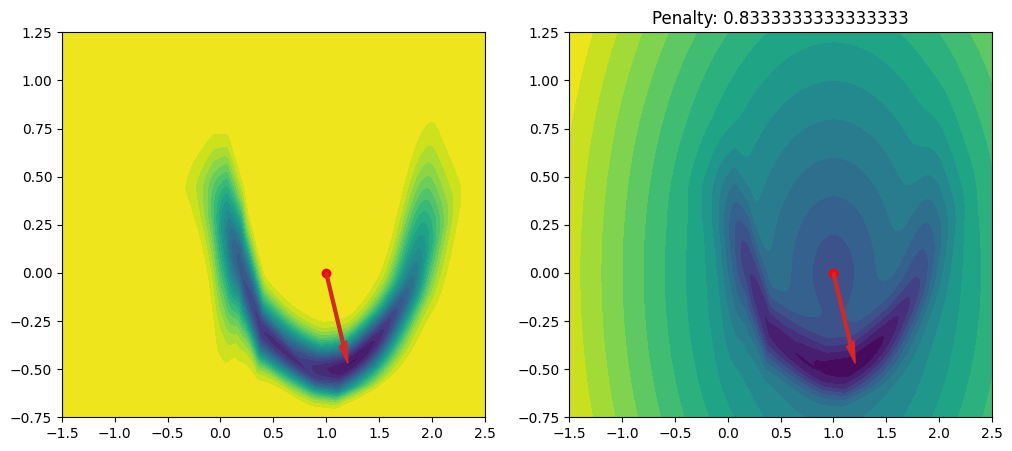

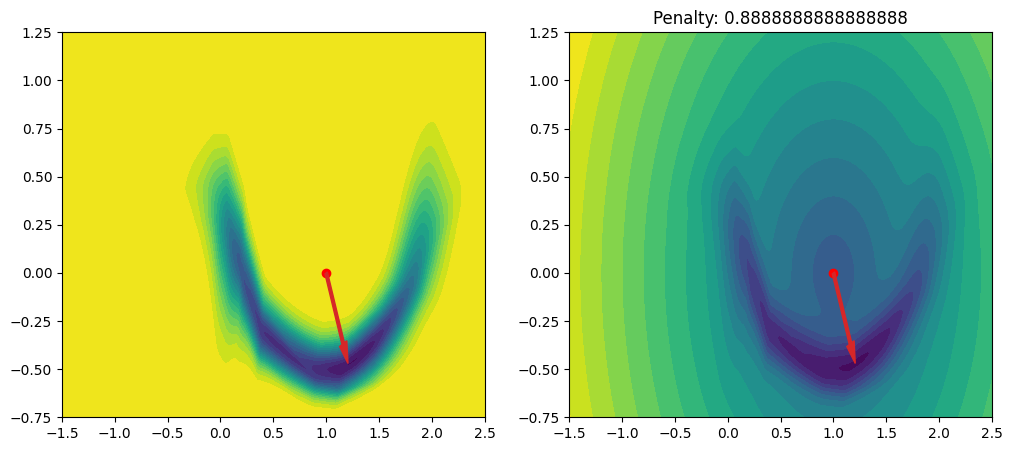

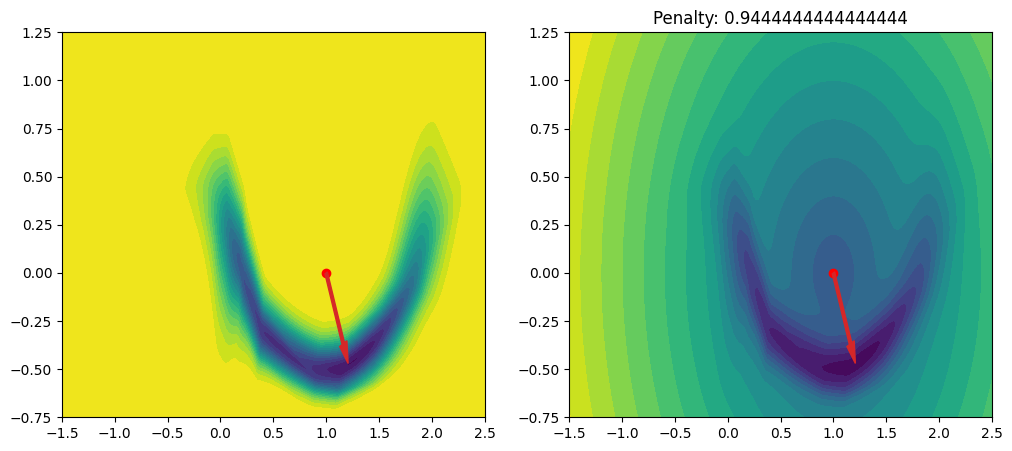

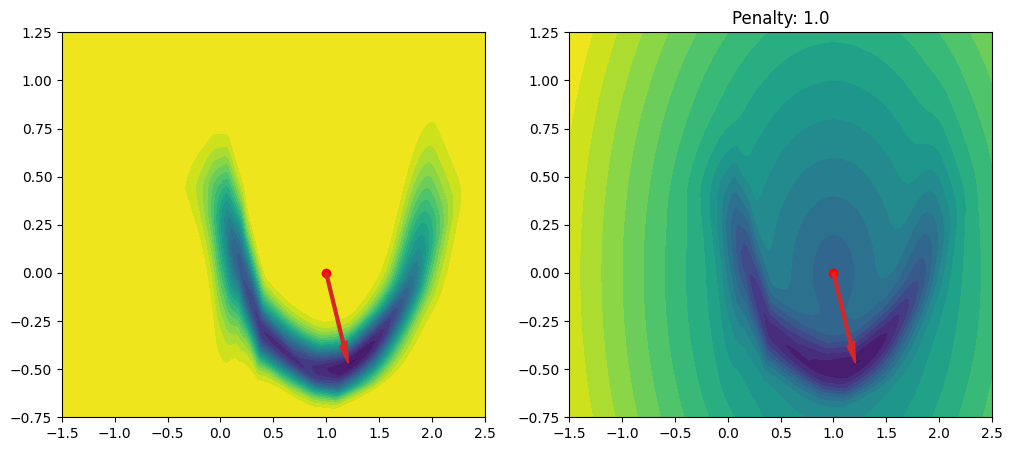

In [111]:
x_init = torch.Tensor([x])
xline = torch.linspace(-1.5, 2.5, 200)
yline = torch.linspace(-.75, 1.25, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for i in np.linspace(0.5, 1, 10):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,5)

    with torch.no_grad():
        zgrid0 = - flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)
        zgrid1 = - i*flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200) + np.linalg.norm(xyinput-x_init.repeat(40000, 1), axis=1).reshape(200, 200)

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy(), levels=20)
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy(), levels=20)
    ax[0].scatter(x_init[0,0], x_init[0,1], c="r")
    ax[1].scatter(x_init[0,0], x_init[0,1], c="r")

    res = minimize(optim_f, x, method="Powell", args=(x, flow, y_0, y_1, i))
    ax[0].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    ax[1].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    plt.title(f"Penalty: {i}")
    plt.show()

$$ \beta = 0.01 $$
$$\theta = \beta + p(x'|y) - p(x'|y') $$
$$agmin\quad d(x, x’) - \alpha*max(\theta, 0)$$

In [102]:
y_0 = torch.Tensor([[0.0]])
y_1 = torch.Tensor([[1.0]])
# x = [0.7,  0.01]
x = [1.,  0.]
print(flow.log_prob(torch.Tensor([x]), context=y_0).detach().item())

def optim_f(x_hat, x_i, model, y_orig, y_hat, alpha=1.0, beta=0.0):
    with torch.no_grad():
        x_i = torch.Tensor([x_i])
        x_hat = torch.Tensor([x_hat])
        # p_orig = model.log_prob(x_hat, context=y_orig).detach().item()
        p_orig = model.log_prob(x_i, context=y_orig).detach().exp().item()
        p_hat = model.log_prob(x_hat, context=y_hat).detach().exp().item()
        dist = np.linalg.norm(x_i-x_hat)
        theta = beta + np.abs(p_orig - p_hat)
        return theta + alpha * dist

res = minimize(optim_f, x, method="Powell", args=(x, flow, y_0, y_1, 0.5))

res.x, flow.log_prob(torch.Tensor([res.x]), context=y_1).detach().item()

-0.5591506958007812


(array([ 0.9779967 , -0.36045248]), -0.5591504573822021)

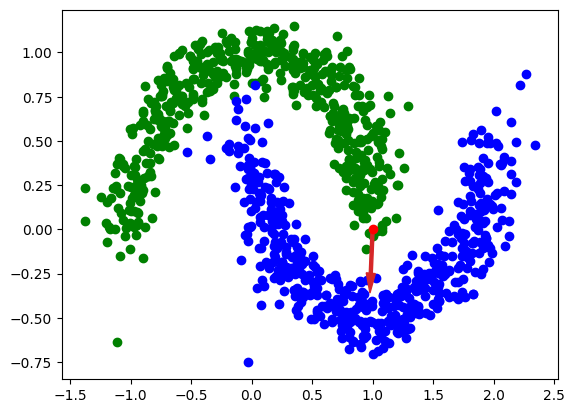

In [103]:
with torch.no_grad():
    samples_zero, log_probs = flow.sample_and_log_prob(512, context=torch.Tensor([[0]]))
    samples_one, log_probs = flow.sample_and_log_prob(512, context=torch.ones(1, 1))
plt.scatter(samples_zero.squeeze()[:, 0], samples_zero.squeeze()[:, 1], c="g")
plt.scatter(samples_one.squeeze()[:, 0], samples_one.squeeze()[:, 1], c="b")
plt.arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
plt.scatter(x[0], x[1], c="r")

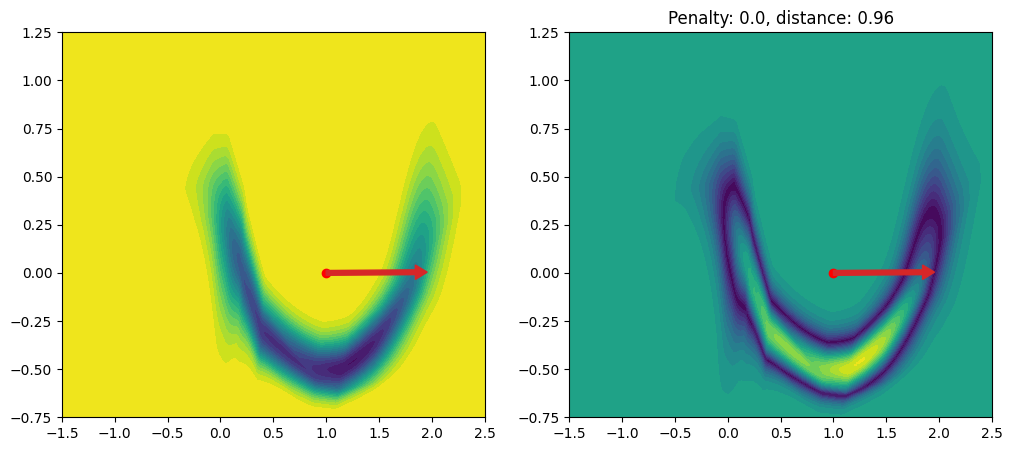

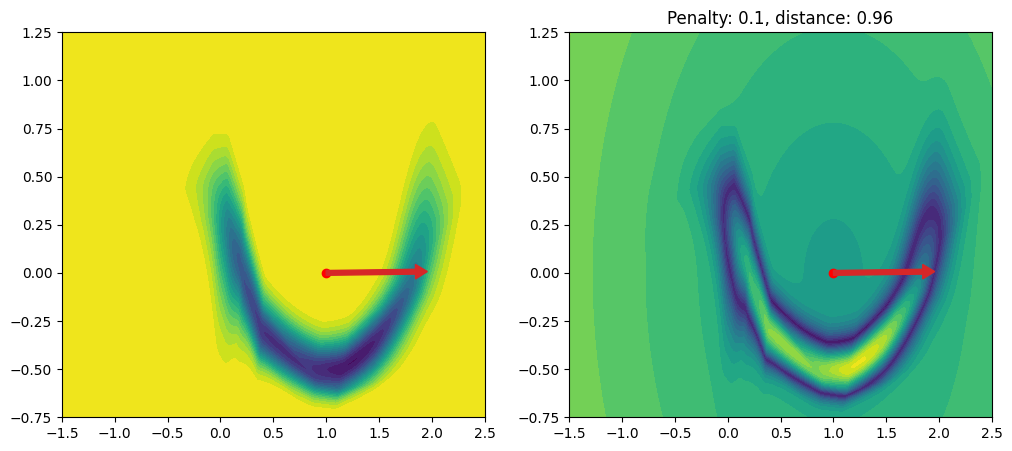

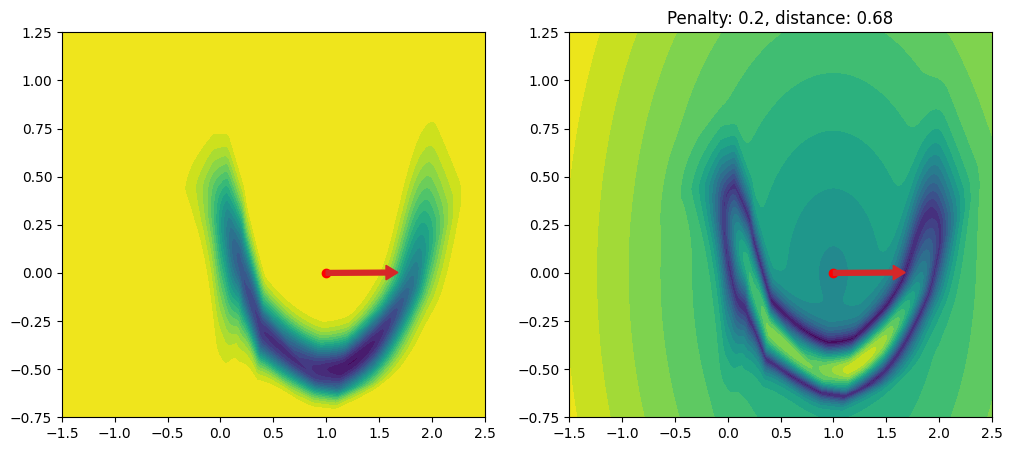

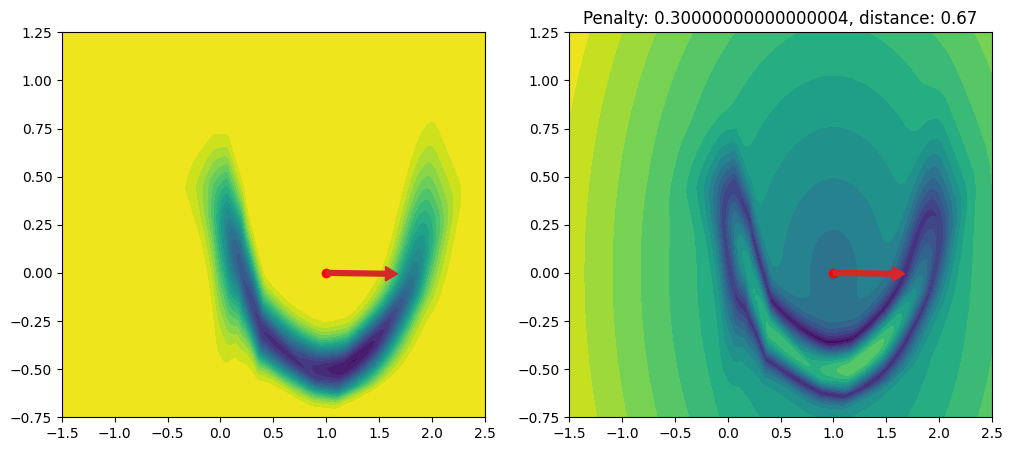

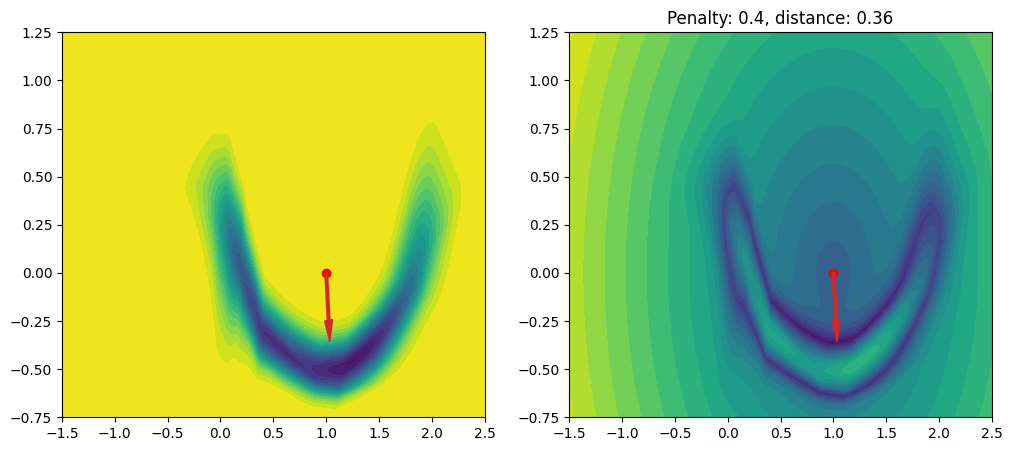

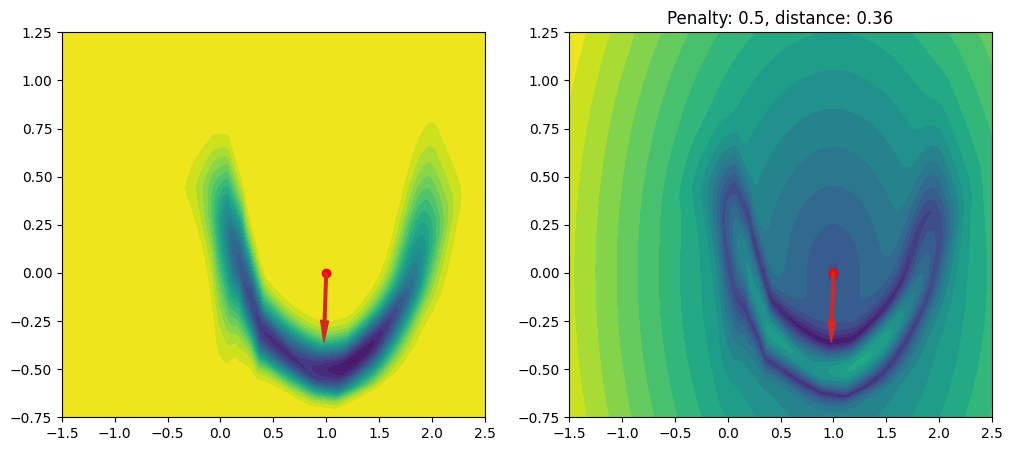

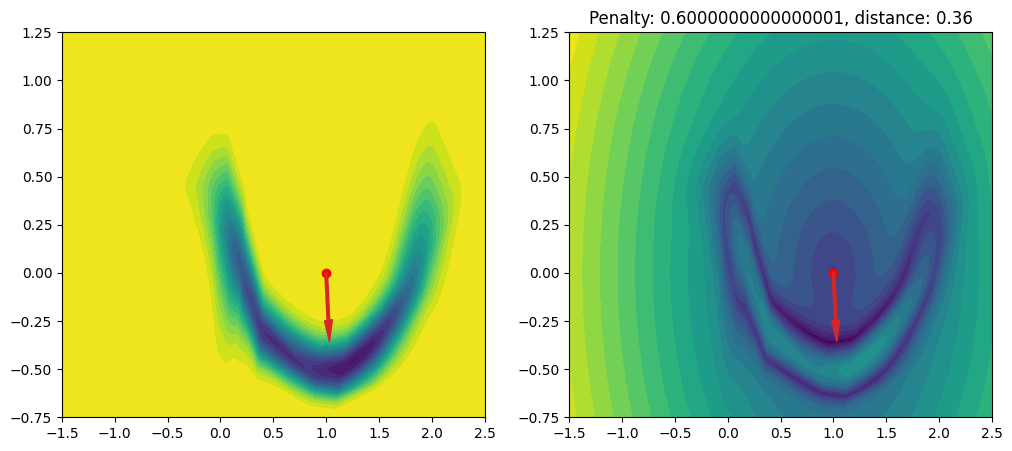

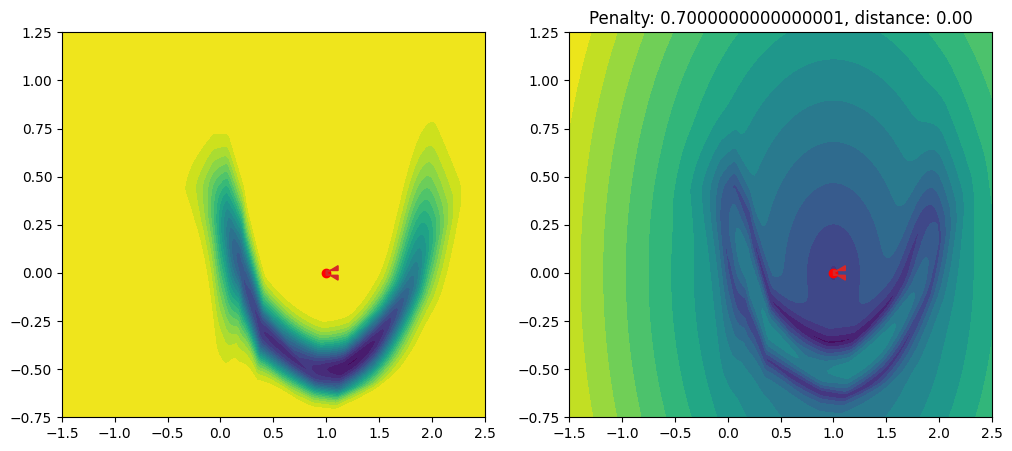

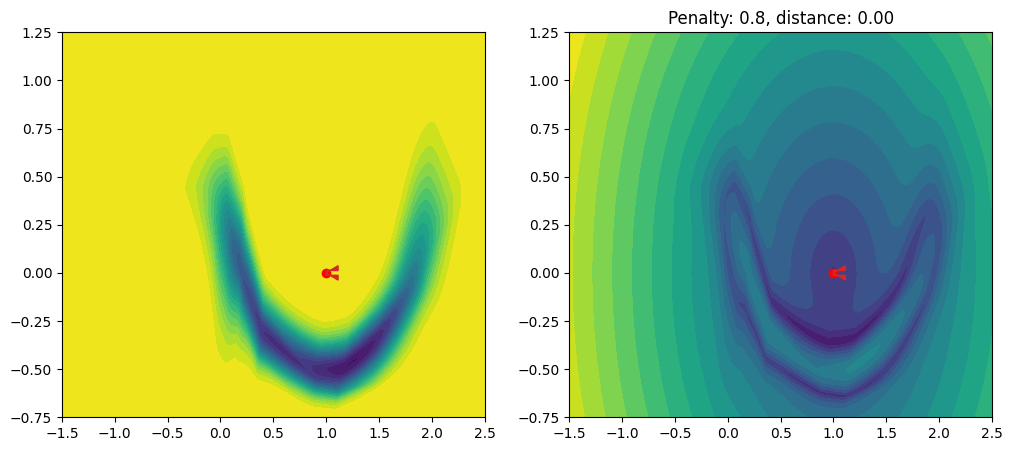

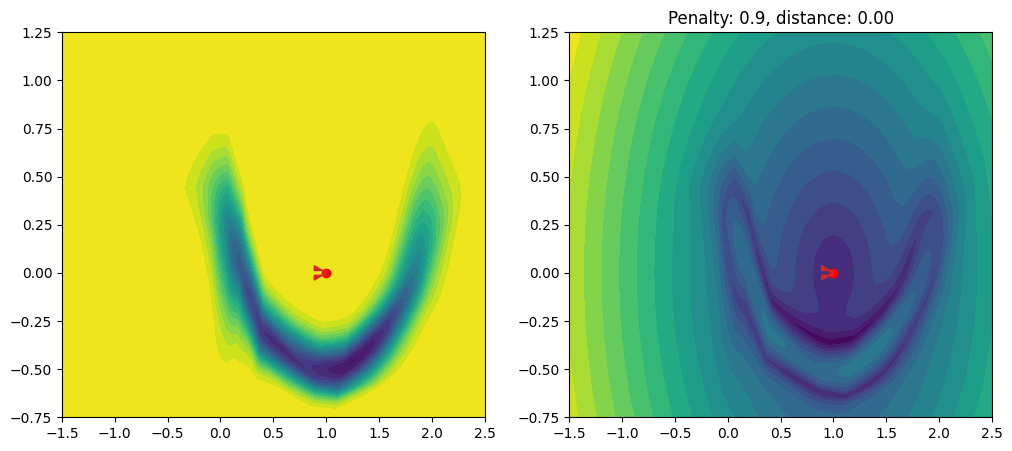

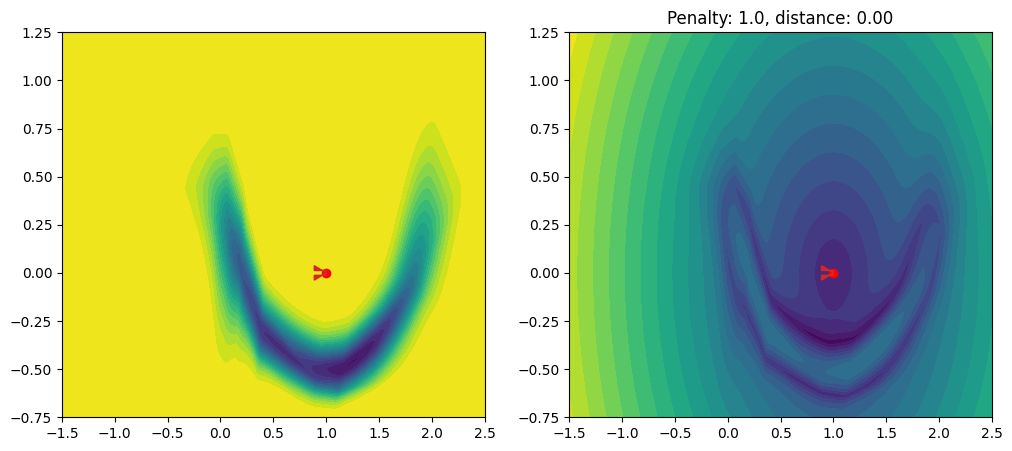

In [105]:
x_init = torch.Tensor([x])
xline = torch.linspace(-1.5, 2.5, 200)
yline = torch.linspace(-.75, 1.25, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for i in np.linspace(0, 1, 11):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12,5)

    with torch.no_grad():
        zgrid0 = - flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)

        dist = np.linalg.norm(xyinput-x_init.repeat(40000, 1), axis=1).reshape(200, 200)
        p_orig = flow.log_prob(x_init, context=torch.Tensor([[0]])).exp().item()
        p_hat = flow.log_prob(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)
        theta = np.abs(p_orig - p_hat)
        zgrid1 = theta + i*dist

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy(), levels=20)
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1, levels=20)
    ax[0].scatter(x_init[0,0], x_init[0,1], c="r")
    ax[1].scatter(x_init[0,0], x_init[0,1], c="r")

    res = minimize(optim_f, x, method="Powell", args=(x, flow, y_0, y_1, i))
    ax[0].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    ax[1].arrow(x[0], x[1], res.x[0]-x[0], res.x[1]-x[1], width=0.025, length_includes_head=True, color="C3")
    plt.title(f"Penalty: {i}, distance: {np.linalg.norm(x_init - res.x):0.2f}")
    plt.show()